<h1>Decision Tree</h1>

In [50]:
import imblearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, f_classif, RFE, RFECV
from sklearn.metrics import auc, accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder

from sklearn import preprocessing

import pickle
from joblib import dump, load


%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 500)

<h2> Understand Data </h2>

In [51]:
#features used to differentiate normal connections from attacks
field_names = pd.read_csv("./Data/Field Names.csv", names=["header", "type"])

added_field_names = pd.DataFrame({"header":["attack", "cnt_correct"],"type":["Nominal", "Count"]})
field_names = field_names.append(added_field_names,sort=False).reset_index().drop("index", axis=1) 

#print data header horizontally for easier viewing
field_names1 = field_names.transpose()
field_names1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42
header,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,cnt_correct
type,Numeric,Nominal,Nominal,Nominal,Numeric,Numeric,Binary,Numeric,Numeric,Numeric,Numeric,Binary,Numeric,Binary,Binary,Numeric,Numeric,Numeric,Numeric,Numeric,Binary,Binary,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Nominal,Count


In [52]:
#Combine data file "KDDTrain+.txt" and  header file "Field Names.csv"
data = pd.read_csv("./Data/KDDTrain+.txt", names=field_names["header"])
data.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,cnt_correct
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


<h2> Prepare Training and Test Data </h2>

In [53]:
#Training Data#
X_train_raw = data.drop(['attack', 'cnt_correct'], axis=1)
Y_train_raw = data[['attack']]

In [54]:
#X_train_raw.head()
print("Train Set shape", X_train_raw.shape)

Train Set shape (125973, 41)


In [55]:
#X_train_raw.head()
print("Train Set shape", Y_train_raw.shape)

Train Set shape (125973, 1)


In [56]:
# Process Training set and test set, converting normal connection to 0, attack to 1. 
for i, row in Y_train_raw.iterrows():
    #print(row['category'])
    if row['attack'] == 'normal':
        row['attack'] = 0
    else:
        row['attack'] = 1

Y_train_raw.head()

,attack
0,0
1,0
2,1
3,0
4,0


In [57]:
#Process Test Data 
data_test = pd.read_csv("./Data/KDDTest+.txt", names=field_names["header"])

X_test_raw = data_test.drop(['attack', 'cnt_correct'], axis=1)
Y_test_raw = data_test[['attack']]

for i, row in Y_test_raw.iterrows():
    #print(row['category'])
    if row['attack'] == 'normal':
        row['attack'] = 0
    else:
        row['attack'] = 1
        
Y_test_raw.head()

,attack
0,1
1,1
2,0
3,1
4,1


In [58]:
#print the shape of the datasets
print("XTrain Set shape", X_train_raw.shape)
print("YTrain Set shape", Y_train_raw.shape)
print("XTest Set shape", X_test_raw.shape)
print("YTest Set shape", Y_test_raw.shape)

XTrain Set shape (125973, 41)
YTrain Set shape (125973, 1)
XTest Set shape (22544, 41)
YTest Set shape (22544, 1)


<h2> Apply One Hot Encoding </h2>

In [59]:
#print columns with categorical data 
field_names.loc[field_names['type'] =='Nominal'] ##only 3 symbolic protocol type, service, flag

,header,type
1,protocol_type,Nominal
2,service,Nominal
3,flag,Nominal
41,attack,Nominal


In [60]:
cat_columns = ["protocol_type", "service","flag"]

X_train = pd.get_dummies(X_train_raw, prefix_sep="__",
                              columns=cat_columns)

X_test = pd.get_dummies(X_test_raw, prefix_sep="__",
                              columns=cat_columns)

In [61]:
print("XTrain Set shape:", X_train.shape)
print("XTest Set shape:", X_test.shape)

XTrain Set shape: (125973, 122)
XTest Set shape: (22544, 116)


In [62]:
# Get missing columns in the training test
missing_cols = set(X_train.columns ) - set(X_test.columns )

# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    X_test[c] = 0
    
# Ensure the order of column in the test set is in the same order than in train set
X_test = X_test[X_train.columns]

In [63]:
print("XTrain Set shape:", X_train.shape)
print("XTest Set shape:", X_test.shape)

XTrain Set shape: (125973, 122)
XTest Set shape: (22544, 122)


In [64]:
X_train.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type__icmp,protocol_type__tcp,protocol_type__udp,service__IRC,service__X11,service__Z39_50,service__aol,service__auth,service__bgp,service__courier,service__csnet_ns,service__ctf,service__daytime,service__discard,service__domain,service__domain_u,service__echo,service__eco_i,service__ecr_i,service__efs,service__exec,service__finger,service__ftp,service__ftp_data,service__gopher,service__harvest,service__hostnames,service__http,service__http_2784,service__http_443,service__http_8001,service__imap4,service__iso_tsap,service__klogin,service__kshell,service__ldap,service__link,service__login,service__mtp,service__name,service__netbios_dgm,service__netbios_ns,service__netbios_ssn,service__netstat,service__nnsp,service__nntp,service__ntp_u,service__other,service__pm_dump,service__pop_2,service__pop_3,service__printer,service__private,service__red_i,service__remote_job,service__rje,service__shell,service__smtp,service__sql_net,service__ssh,service__sunrpc,service__supdup,service__systat,service__telnet,service__tftp_u,service__tim_i,service__time,service__urh_i,service__urp_i,service__uucp,service__uucp_path,service__vmnet,service__whois,flag__OTH,flag__REJ,flag__RSTO,flag__RSTOS0,flag__RSTR,flag__S0,flag__S1,flag__S2,flag__S3,flag__SF,flag__SH
0,0,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [65]:
X_test.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type__icmp,protocol_type__tcp,protocol_type__udp,service__IRC,service__X11,service__Z39_50,service__aol,service__auth,service__bgp,service__courier,service__csnet_ns,service__ctf,service__daytime,service__discard,service__domain,service__domain_u,service__echo,service__eco_i,service__ecr_i,service__efs,service__exec,service__finger,service__ftp,service__ftp_data,service__gopher,service__harvest,service__hostnames,service__http,service__http_2784,service__http_443,service__http_8001,service__imap4,service__iso_tsap,service__klogin,service__kshell,service__ldap,service__link,service__login,service__mtp,service__name,service__netbios_dgm,service__netbios_ns,service__netbios_ssn,service__netstat,service__nnsp,service__nntp,service__ntp_u,service__other,service__pm_dump,service__pop_2,service__pop_3,service__printer,service__private,service__red_i,service__remote_job,service__rje,service__shell,service__smtp,service__sql_net,service__ssh,service__sunrpc,service__supdup,service__systat,service__telnet,service__tftp_u,service__tim_i,service__time,service__urh_i,service__urp_i,service__uucp,service__uucp_path,service__vmnet,service__whois,flag__OTH,flag__REJ,flag__RSTO,flag__RSTOS0,flag__RSTR,flag__S0,flag__S1,flag__S2,flag__S3,flag__SF,flag__SH
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,229,10,0.0,0.00,1.0,1.0,0.04,0.06,0.00,255,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,1,0.0,0.00,1.0,1.0,0.01,0.06,0.00,255,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,2,12983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.00,0.0,0.0,1.00,0.00,0.00,134,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,65,0.0,0.00,0.0,0.0,1.00,0.00,1.00,3,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,1,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,0.0,0.12,1.0,0.5,1.00,0.00,0.75,29,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [66]:
y_train = Y_train_raw.astype('int')
y_test = Y_test_raw.astype('int')

<h2> Apply Decision Tree Without Data Processing </h2>

In [67]:
dt = DecisionTreeClassifier(criterion='entropy',random_state=0)
dt.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(dt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(dt.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.787


In [68]:
#fit the data
y_pred = dt.predict(X_test)

In [69]:
#print report
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred)) 

[[9351  360]
 [4443 8390]]
             precision    recall  f1-score   support

          0       0.68      0.96      0.80      9711
          1       0.96      0.65      0.78     12833

avg / total       0.84      0.79      0.79     22544



<h2> Normalization </h2>

In [70]:
X_train.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type__icmp,protocol_type__tcp,protocol_type__udp,service__IRC,service__X11,service__Z39_50,service__aol,service__auth,service__bgp,service__courier,service__csnet_ns,service__ctf,service__daytime,service__discard,service__domain,service__domain_u,service__echo,service__eco_i,service__ecr_i,service__efs,service__exec,service__finger,service__ftp,service__ftp_data,service__gopher,service__harvest,service__hostnames,service__http,service__http_2784,service__http_443,service__http_8001,service__imap4,service__iso_tsap,service__klogin,service__kshell,service__ldap,service__link,service__login,service__mtp,service__name,service__netbios_dgm,service__netbios_ns,service__netbios_ssn,service__netstat,service__nnsp,service__nntp,service__ntp_u,service__other,service__pm_dump,service__pop_2,service__pop_3,service__printer,service__private,service__red_i,service__remote_job,service__rje,service__shell,service__smtp,service__sql_net,service__ssh,service__sunrpc,service__supdup,service__systat,service__telnet,service__tftp_u,service__tim_i,service__time,service__urh_i,service__urp_i,service__uucp,service__uucp_path,service__vmnet,service__whois,flag__OTH,flag__REJ,flag__RSTO,flag__RSTOS0,flag__RSTR,flag__S0,flag__S1,flag__S2,flag__S3,flag__SF,flag__SH
0,0,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [71]:
# Replace the following columns with the log of themselves 
'''If you have variables that always get positive numbers, such as lenght, weight, etc., and that showes 
much more variation with higher values (heteroscedasticity), a log-normal distribution (i.e., normal after 
log-transformation) might be a clearly better description of the data than a normal distribution.
Log-transforming that kind of variables makes the distributions more normally distributed, stabilizes the variances, 
but also makes your model multiplative on the raw scale instead of additive. '''

log_cols = ["duration", "src_bytes", "dst_bytes", "hot", "num_failed_logins", "num_compromised", "num_root", "num_file_creations", 
            "num_shells", "num_access_files"]

dataframe = X_train

for log_col in log_cols:
    if log_col in dataframe.columns:
        print("Processing column: %s" %(log_col))
        dataframe[log_col] = dataframe[log_col].map(lambda x: max(np.log(x), 0))
    else:
        pass

Processing column: duration
Processing column: src_bytes
Processing column: dst_bytes
Processing column: hot
Processing column: num_failed_logins
Processing column: num_compromised
Processing column: num_root
Processing column: num_file_creations
Processing column: num_shells
Processing column: num_access_files


In [72]:
#Normalize columns with numeric data (binary data is not normalized)
numeric_cols = list(field_names["header"][field_names["type"] == "Numeric"])
numeric_cols.remove("num_outbound_cmds")
print(numeric_cols)

['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'num_compromised', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']


In [73]:
#normalize these columns
X_train_norm = dataframe

norm_type = "mean-std"

for numeric_col in numeric_cols:
    print("Processing column: %s" %(numeric_col))
    tr_values = X_train_norm[numeric_col]
    
    if norm_type == "min-max":
        X_train_norm[numeric_col] = (tr_values - np.min(tr_values))/(np.max(tr_values) - np.min(tr_values))
        X_train_norm[numeric_col] = X_train_norm[numeric_col].astype("float64")
    elif norm_type == "mean-std":
        X_train_norm[numeric_col] = (tr_values - np.min(tr_values))/np.std(tr_values)
        X_train_norm[numeric_col] = X_train_norm[numeric_col].astype("float64")
    else:
        pass

Processing column: duration
Processing column: src_bytes
Processing column: dst_bytes
Processing column: wrong_fragment
Processing column: urgent
Processing column: hot
Processing column: num_failed_logins
Processing column: num_compromised
Processing column: num_root
Processing column: num_file_creations
Processing column: num_shells
Processing column: num_access_files
Processing column: count
Processing column: srv_count
Processing column: serror_rate
Processing column: srv_serror_rate
Processing column: rerror_rate
Processing column: srv_rerror_rate
Processing column: same_srv_rate
Processing column: diff_srv_rate
Processing column: srv_diff_host_rate
Processing column: dst_host_count
Processing column: dst_host_srv_count
Processing column: dst_host_same_srv_rate
Processing column: dst_host_diff_srv_rate
Processing column: dst_host_same_src_port_rate
Processing column: dst_host_srv_diff_host_rate
Processing column: dst_host_serror_rate
Processing column: dst_host_srv_serror_rate
Pro

In [74]:
X_train_norm.head(5)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type__icmp,protocol_type__tcp,protocol_type__udp,service__IRC,service__X11,service__Z39_50,service__aol,service__auth,service__bgp,service__courier,service__csnet_ns,service__ctf,service__daytime,service__discard,service__domain,service__domain_u,service__echo,service__eco_i,service__ecr_i,service__efs,service__exec,service__finger,service__ftp,service__ftp_data,service__gopher,service__harvest,service__hostnames,service__http,service__http_2784,service__http_443,service__http_8001,service__imap4,service__iso_tsap,service__klogin,service__kshell,service__ldap,service__link,service__login,service__mtp,service__name,service__netbios_dgm,service__netbios_ns,service__netbios_ssn,service__netstat,service__nnsp,service__nntp,service__ntp_u,service__other,service__pm_dump,service__pop_2,service__pop_3,service__printer,service__private,service__red_i,service__remote_job,service__rje,service__shell,service__smtp,service__sql_net,service__ssh,service__sunrpc,service__supdup,service__systat,service__telnet,service__tftp_u,service__tim_i,service__time,service__urh_i,service__urp_i,service__uucp,service__uucp_path,service__vmnet,service__whois,flag__OTH,flag__REJ,flag__RSTO,flag__RSTOS0,flag__RSTR,flag__S0,flag__S1,flag__S2,flag__S3,flag__SF,flag__SH
0,0.0,2.068858,0.000000,0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0.017466,0.027535,0.000000,0.000000,0.0,0.0,2.274686,0.000000,0.000000,1.512008,0.225831,0.378663,0.158796,0.550169,0.000000,0.000000,0.000000,0.163102,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0.0,1.663918,0.000000,0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0.113529,0.013767,0.000000,0.000000,0.0,0.0,0.181975,0.831884,0.000000,2.570414,0.009033,0.000000,3.175930,2.847934,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0.0,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,1.074159,0.082604,2.239873,2.237033,0.0,0.0,0.113734,0.388212,0.000000,2.570414,0.234864,0.222743,0.264661,0.000000,0.000000,2.248291,2.243826,0.000000,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0.0,1.818547,2.537965,0,0.0,0.0,0.0,0.0,1,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0.043665,0.068837,0.447975,0.447407,0.0,0.0,2.274686,0.000000,0.000000,0.302402,2.303475,2.227432,0.000000,0.097089,0.355355,0.067449,0.022438,0.000000,0.031303,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0.0,1.767319,1.702167,0,0.0,0.0,0.0,0.0,1,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0.261990,0.440556,0.000000,0.000000,0.0,0.0,2.274686,0.000000,0.346381,2.570414,2.303475,2.227432,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [75]:
# Replace the following columns with the log of themselves because they have very big range
dataframe_test = X_test

for log_col in log_cols:
    if log_col in dataframe_test.columns:
        print("Processing column: %s" %(log_col))
        dataframe_test[log_col] = dataframe_test[log_col].map(lambda x: max(np.log(x), 0))
    else:
        pass

Processing column: duration
Processing column: src_bytes
Processing column: dst_bytes
Processing column: hot
Processing column: num_failed_logins
Processing column: num_compromised
Processing column: num_root
Processing column: num_file_creations
Processing column: num_shells
Processing column: num_access_files


In [76]:
#normalize these columns
X_test_norm = dataframe_test

#normalisation
for numeric_col in numeric_cols:
    print("Processing column: %s" %(numeric_col))
    values_test = X_test_norm[numeric_col]
    
    if norm_type == "min-max":
        X_test_norm[numeric_col] = (values_test - np.min(values_test))/(np.max(values_test) - np.min(values_test))
        X_test_norm[numeric_col] = X_test_norm[numeric_col].astype("float64")
    elif norm_type == "mean-std":
        X_test_norm[numeric_col] = (values_test - np.min(values_test))/np.std(values_test)
        X_test_norm[numeric_col] = X_test_norm[numeric_col].astype("float64")
    else:
        pass

Processing column: duration
Processing column: src_bytes
Processing column: dst_bytes
Processing column: wrong_fragment
Processing column: urgent
Processing column: hot
Processing column: num_failed_logins
Processing column: num_compromised
Processing column: num_root
Processing column: num_file_creations
Processing column: num_shells
Processing column: num_access_files
Processing column: count
Processing column: srv_count
Processing column: serror_rate
Processing column: srv_serror_rate
Processing column: rerror_rate
Processing column: srv_rerror_rate
Processing column: same_srv_rate
Processing column: diff_srv_rate
Processing column: srv_diff_host_rate
Processing column: dst_host_count
Processing column: dst_host_srv_count
Processing column: dst_host_same_srv_rate
Processing column: dst_host_diff_srv_rate
Processing column: dst_host_same_src_port_rate
Processing column: dst_host_srv_diff_host_rate
Processing column: dst_host_serror_rate
Processing column: dst_host_srv_serror_rate
Pro

In [77]:
X_test_norm.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type__icmp,protocol_type__tcp,protocol_type__udp,service__IRC,service__X11,service__Z39_50,service__aol,service__auth,service__bgp,service__courier,service__csnet_ns,service__ctf,service__daytime,service__discard,service__domain,service__domain_u,service__echo,service__eco_i,service__ecr_i,service__efs,service__exec,service__finger,service__ftp,service__ftp_data,service__gopher,service__harvest,service__hostnames,service__http,service__http_2784,service__http_443,service__http_8001,service__imap4,service__iso_tsap,service__klogin,service__kshell,service__ldap,service__link,service__login,service__mtp,service__name,service__netbios_dgm,service__netbios_ns,service__netbios_ssn,service__netstat,service__nnsp,service__nntp,service__ntp_u,service__other,service__pm_dump,service__pop_2,service__pop_3,service__printer,service__private,service__red_i,service__remote_job,service__rje,service__shell,service__smtp,service__sql_net,service__ssh,service__sunrpc,service__supdup,service__systat,service__telnet,service__tftp_u,service__tim_i,service__time,service__urh_i,service__urp_i,service__uucp,service__uucp_path,service__vmnet,service__whois,flag__OTH,flag__REJ,flag__RSTO,flag__RSTOS0,flag__RSTR,flag__S0,flag__S1,flag__S2,flag__S3,flag__SF,flag__SH
0,0.000000,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,1.781597,0.112283,0.0,0.000000,2.40322,2.402658,0.096973,0.231542,0.000000,2.711797,0.089460,0.091811,0.271848,0.000000,0.000000,0.0,0.0,2.582510,2.494599,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0.000000,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,1.058066,0.011228,0.0,0.000000,2.40322,2.402658,0.024243,0.231542,0.000000,2.711797,0.008946,0.000000,0.271848,0.000000,0.000000,0.0,0.0,2.582510,2.494599,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0.358104,2.982939,0.000000,0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0.007780,0.011228,0.0,0.000000,0.00000,0.000000,2.424320,0.000000,0.000000,1.425023,0.769358,1.400115,0.181232,1.991762,0.234214,0.0,0.0,0.000000,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0.000000,0.943481,0.000000,0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0.007780,0.729840,0.0,0.000000,0.00000,0.000000,2.424320,0.000000,3.944156,0.031903,0.509923,2.295271,0.000000,3.265184,3.278996,0.0,0.0,0.000000,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0.000000,0.000000,0.788089,0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0.007780,0.089827,0.0,0.402246,2.40322,1.201329,2.424320,0.000000,2.958117,0.308400,0.769358,0.711534,0.770235,0.097956,0.234214,0.0,0.0,2.143483,1.771165,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [78]:
print("XTrain Set shape:",X_train_norm.shape)
print("XTest Set shape:", X_test_norm.shape)

XTrain Set shape: (125973, 122)
XTest Set shape: (22544, 122)


<h2> Apply Decision Tree After Data Normalisation </h2>

In [79]:
dt_norm = DecisionTreeClassifier(criterion='entropy',random_state=0)
dt_norm.fit(X_train_norm, y_train)
print("Accuracy on normalized training set: {:.3f}".format(dt_norm.score(X_train_norm, y_train)))
print("Accuracy on normalized test set: {:.3f}".format(dt_norm.score(X_test_norm, y_test)))

Accuracy on normalized training set: 1.000
Accuracy on normalized test set: 0.783


In [80]:
#fit the data
y_pred_norm = dt_norm.predict(X_test_norm)

In [81]:
#print report
print(confusion_matrix(y_test, y_pred_norm))  
print(classification_report(y_test, y_pred_norm))

[[9261  450]
 [4432 8401]]
             precision    recall  f1-score   support

          0       0.68      0.95      0.79      9711
          1       0.95      0.65      0.77     12833

avg / total       0.83      0.78      0.78     22544



<h2> Apply Variance Thresholding </h2>

In [82]:
# Create VarianceThreshold object with a variance with a threshold of 0.5
thresholder = VarianceThreshold(threshold=.90)

# Conduct variance thresholding
X_train_var = thresholder.fit_transform(X_train_norm)
X_test_var = thresholder.fit_transform(X_test_norm)

In [83]:
print("XTrain Set shape:",X_train_var.shape)
print("XTest Set shape:", X_test_var.shape)

XTrain Set shape: (125973, 31)
XTest Set shape: (22544, 31)


<h2> Apply KNN After Variance Thresholding </h2>

In [84]:
dt_var = DecisionTreeClassifier(criterion='entropy',random_state=0)
dt_var.fit(X_train_var, y_train)
print("Accuracy on normalized training set: {:.3f}".format(dt_var.score(X_train_var, y_train)))
print("Accuracy on normalized test set: {:.3f}".format(dt_var.score(X_test_var, y_test)))

Accuracy on normalized training set: 1.000
Accuracy on normalized test set: 0.789


In [85]:
#fit the data
y_pred_var = dt_var.predict(X_test_var)

In [86]:
#print report
print(confusion_matrix(y_test, y_pred_var))  
print(classification_report(y_test, y_pred_var))

[[9428  283]
 [4479 8354]]
             precision    recall  f1-score   support

          0       0.68      0.97      0.80      9711
          1       0.97      0.65      0.78     12833

avg / total       0.84      0.79      0.79     22544



<h2> Apply F-Test </h2>

In [87]:
#Set how floating-point errors are handled.
np.seterr(divide='ignore', invalid='ignore');

In [88]:
selector = SelectPercentile(f_classif, percentile=10)
selector = selector.fit(X_train_norm, y_train.values.ravel())

C:\Users\meiro\.conda\envs\prmls\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [16] are constant.
  UserWarning)


In [89]:
X_train_f = list(X_train_norm.columns[selector.get_support(indices=True)])
X_train_f 

C:\Users\meiro\.conda\envs\prmls\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


['src_bytes',
 'dst_bytes',
 'logged_in',
 'count',
 'serror_rate',
 'srv_serror_rate',
 'same_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'flag__S0',
 'flag__SF']

<h2> Apply Decision Tree After F-test </h2>

In [90]:
dt_f = DecisionTreeClassifier(criterion='entropy',random_state=0)
dt_f.fit(X_train_norm[X_train_f], y_train)
print("Accuracy on normalized training set: {:.3f}".format(dt_f.score(X_train_norm[X_train_f], y_train)))
print("Accuracy on normalized test set: {:.3f}".format(dt_f.score(X_test_norm[X_train_f], y_test)))

Accuracy on normalized training set: 1.000
Accuracy on normalized test set: 0.776


In [91]:
#fit the data
y_pred_f = dt_f.predict(X_test_norm[X_train_f])

In [92]:
#print report
print(confusion_matrix(y_test, y_pred_f))  
print(classification_report(y_test, y_pred_f))

[[9374  337]
 [4706 8127]]
             precision    recall  f1-score   support

          0       0.67      0.97      0.79      9711
          1       0.96      0.63      0.76     12833

avg / total       0.83      0.78      0.77     22544



<h2> Apply RFE </h2>

<p> Feature ranking with recursive feature elimination.
  

In [93]:
dt_rfe = RFE(estimator=DecisionTreeClassifier(random_state=0), n_features_to_select=15, step=1)
dt_rfe.fit(X_train_norm, y_train.values.ravel())

RFE(estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'),
  n_features_to_select=15, step=1, verbose=0)

In [94]:
rfe_features = list(X_train.columns[dt_rfe.get_support(indices=True)])
rfe_features

['duration',
 'src_bytes',
 'dst_bytes',
 'hot',
 'logged_in',
 'rerror_rate',
 'dst_host_same_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_rerror_rate',
 'service__ecr_i',
 'service__ftp_data',
 'service__http',
 'service__private']

<h2> Apply Decision Tree After RFE </h2>

In [95]:
print("Accuracy on normalized training set: {:.3f}".format(dt_rfe.score(X_train_norm, y_train)))
print("Accuracy on normalized test set: {:.3f}".format(dt_rfe.score(X_test_norm, y_test)))

Accuracy on normalized training set: 1.000
Accuracy on normalized test set: 0.826


In [96]:
#predict the data
y_pred_rfe = dt_rfe.predict(X_test_norm)

In [97]:
#print report
print(confusion_matrix(y_test, y_pred_rfe))  
print(classification_report(y_test, y_pred_rfe))

[[8681 1030]
 [2894 9939]]
             precision    recall  f1-score   support

          0       0.75      0.89      0.82      9711
          1       0.91      0.77      0.84     12833

avg / total       0.84      0.83      0.83     22544



<h2> Apply PCA </h2>

In [98]:
# correlation matrix (before stdze)
corm = X_train_norm.corr()
print('Corelation Matrix:\n',corm)

Corelation Matrix:
                 duration  src_bytes  dst_bytes      land  wrong_fragment  \
duration        1.000000  0.079578   0.076595  -0.002965 -0.018832         
src_bytes       0.079578  1.000000   0.703414  -0.015090  0.011926         
dst_bytes       0.076595  0.703414   1.000000  -0.012235 -0.077538         
land           -0.002965 -0.015090  -0.012235   1.000000 -0.001261         
wrong_fragment -0.018832  0.011926  -0.077538  -0.001261  1.000000         
...                  ...       ...        ...        ...       ...         
flag__S1       -0.011344  0.048559   0.059948  -0.000759 -0.004824         
flag__S2        0.003687  0.027261   0.012499  -0.000448 -0.002843         
flag__S3        0.010986  0.025419   0.010284  -0.000278 -0.001765         
flag__SF        0.036699  0.851260   0.687532  -0.017074  0.073840         
flag__SH       -0.009771 -0.049731  -0.040323  -0.000654 -0.004155         

                  urgent       hot  num_failed_logins  logged_in  \

<p>Observation: None of the fields is highly correlated </p>

In [99]:
sumry = X_train_norm.describe().transpose()
print("Summary Statistics:\n",sumry,'\n')

Summary Statistics:
                    count      mean       std  min  25%       50%       75%  \
duration        125973.0  0.210445  1.000004  0.0  0.0  0.000000  0.000000   
src_bytes       125973.0  1.071049  1.000004  0.0  0.0  1.263459  1.876530   
dst_bytes       125973.0  0.868449  1.000004  0.0  0.0  0.000000  1.760177   
land            125973.0  0.000198  0.014086  0.0  0.0  0.000000  0.000000   
wrong_fragment  125973.0  0.089486  1.000004  0.0  0.0  0.000000  0.000000   
...                  ...       ...       ...  ...  ...       ...       ...   
flag__S1        125973.0  0.002897  0.053750  0.0  0.0  0.000000  0.000000   
flag__S2        125973.0  0.001008  0.031736  0.0  0.0  0.000000  0.000000   
flag__S3        125973.0  0.000389  0.019719  0.0  0.0  0.000000  0.000000   
flag__SF        125973.0  0.594929  0.490908  0.0  0.0  1.000000  1.000000   
flag__SH        125973.0  0.002151  0.046332  0.0  0.0  0.000000  0.000000   

                      max  
duration      

In [100]:
# Apply PCA. Get Eigenvctors, Eigenvalues
# Loadings = Correlation coefficient betwn PC & feature
features = list(X_train_norm)
colnames = np.transpose(features)

n_components = len(features)
pca = PCA(n_components).fit(X_train_norm)

# generate PC labels:
PCs=[]
for l in range(1,n_components+1):
    PCs.append("PC"+str(l))
    
# Get Eigenvectors & Eigenvalues
eigvec = pca.components_.transpose()
eigval = pca.explained_variance_ 

# Calculate Loadings = Eigenvector * SQRT(Eigenvalue)
print('Loading Matrix:'); loadings= np.sqrt(eigval)*eigvec
print(pd.DataFrame(loadings,columns=PCs,index=colnames),'\n')

Loading Matrix:
                     PC1       PC2       PC3       PC4       PC5       PC6  \
duration       -0.050047  0.239957  0.344319 -0.148337  0.165898 -0.594745   
src_bytes      -0.832616 -0.196117  0.056018  0.144518  0.122547 -0.202864   
dst_bytes      -0.758683 -0.213108  0.054694  0.369761 -0.205734 -0.179116   
land            0.000053 -0.000096  0.000012 -0.000874 -0.000244  0.000265   
wrong_fragment -0.013684  0.020955  0.000348 -0.051998  0.214557 -0.078254   
...                  ...       ...       ...       ...       ...       ...   
flag__S1       -0.000892 -0.001356  0.002320  0.000384 -0.002150 -0.000560   
flag__S2       -0.000445 -0.000472  0.000038 -0.000114 -0.000767 -0.000235   
flag__S3       -0.000146 -0.000127  0.000143 -0.000020 -0.000173 -0.000240   
flag__SF       -0.445636 -0.096314  0.009603 -0.008545  0.106995 -0.056877   
flag__SH        0.002135 -0.000283  0.000816 -0.004027  0.000900 -0.003358   

                     PC7       PC8       PC9   

In [116]:
#Print out Eigenvectors
print('\nEigenvectors (Linear Coefficients):')
print(pd.DataFrame(eigvec,columns=PCs,index=colnames),'\n')

var_expln= pca.explained_variance_ratio_ * 100
eigval = -np.sort(-eigval) #descending
npc = 15 # display-1
print("Eigenvalues   :",eigval[0:npc])
print("%Explained_Var:",var_expln[0:npc])
print("%Cumulative   :",np.cumsum(var_expln[0:npc]))
print('\n')


Eigenvectors (Linear Coefficients):
                     PC1       PC2       PC3       PC4       PC5       PC6  \
duration       -0.017397  0.106749  0.221030 -0.103475  0.124897 -0.469789   
src_bytes      -0.289421 -0.087246  0.035960  0.100810  0.092260 -0.160242   
dst_bytes      -0.263722 -0.094805  0.035110  0.257932 -0.154888 -0.141484   
land            0.000018 -0.000043  0.000008 -0.000609 -0.000183  0.000209   
wrong_fragment -0.004757  0.009322  0.000223 -0.036272  0.161530 -0.061813   
...                  ...       ...       ...       ...       ...       ...   
flag__S1       -0.000310 -0.000603  0.001489  0.000268 -0.001619 -0.000442   
flag__S2       -0.000155 -0.000210  0.000024 -0.000080 -0.000578 -0.000186   
flag__S3       -0.000051 -0.000056  0.000091 -0.000014 -0.000130 -0.000190   
flag__SF       -0.154905 -0.042847  0.006164 -0.005961  0.080552 -0.044927   
flag__SH        0.000742 -0.000126  0.000524 -0.002809  0.000677 -0.002653   

                     PC7  

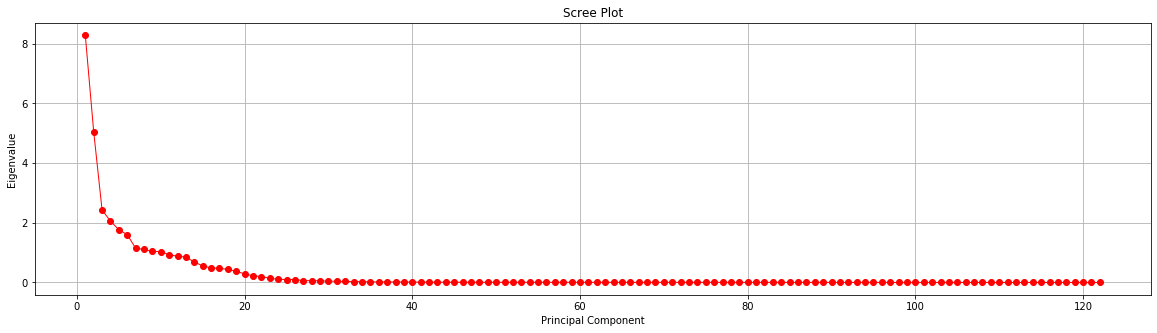

In [102]:
# scree plot
num_vars= len(features)
fig = plt.figure(figsize=(20,5))
sing_vals = np.arange(num_vars) + 1

plt.plot(sing_vals, eigval, 'ro-', linewidth=1)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.grid(); plt.show()

<P> The original data has 122 columns. In this section, the code projects the original data which is 122 dimensional into 2 dimensions. I should note that after dimensionality reduction, there usually isn’t a particular meaning assigned to each principal component. The new components are just the two main dimensions of variation.</p>

In [103]:
#PCA Projection to 9D
pca_2D = PCA(n_components=2)
principalComponents = pca_2D.fit_transform(X_train_norm)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [104]:
finalDf = pd.concat([principalDf, y_train], axis = 1)

In [105]:
finalDf.head()

,principal component 1,principal component 2,attack
0,-0.917040,-0.063065,0
1,0.401358,1.037539,0
2,3.955818,-1.730623,1
3,-2.810048,-0.950126,0
4,-2.400080,-0.748552,0


<p> The explained variance tells you how much information (variance) can be attributed to each of the principal components. This is important as while you can convert 122 dimensional space to 2 dimensional space, you lose some of the variance (information) when you do this. By using the attribute explained_variance_ratio_, you can see that the first principal component contains 25.09% of the variance and the second principal component contains 15.32% of the variance. Together, the two components contain 40.41% of the information.</p>

In [106]:
pca_2D.explained_variance_ratio_

array([0.25093262, 0.15320326])

<P> The original data has 122 columns. In this section, the code projects the original data which is 122 dimensional into 7 dimensions based on the scree plot. I should note that after dimensionality reduction, there usually isn’t a particular meaning assigned to each principal component. The new components are just the two main dimensions of variation.</p>

In [107]:
#PCA Projection to 7D
pca_7D = PCA(n_components=7)
pca_7D.fit_transform(X_train_norm)

array([[-0.9170399 , -0.06306546,  0.10213332, ...,  0.21578774,
        -0.62574392, -0.17926134],
       [ 0.40135827,  1.03753872,  0.42335657, ...,  1.95378067,
        -2.10342411, -0.93083896],
       [ 3.95581769, -1.73062304,  0.01653284, ..., -0.47924064,
         0.01541757,  0.02223196],
       ...,
       [-0.8804901 , -0.72110428,  0.19907344, ..., -0.14481563,
        -1.15894312, -0.2245281 ],
       [ 4.00991211, -1.74071553,  0.02762137, ..., -0.39572824,
         0.04794323,  0.07954913],
       [-0.97945248, -0.17267523,  0.05324094, ...,  0.42006379,
        -0.63219424, -0.2013763 ]])

In [108]:
pca_7D.explained_variance_ratio_

array([0.25093262, 0.15320326, 0.07357803, 0.06231041, 0.05349411,
       0.04859428, 0.03481711])

<p>Together, 7 dimensions contain 68.33% of the information which is not high enough. Try 15 components </p>

In [109]:
#PCA Projection to 16D
pca_16D = PCA(n_components=16)
pca_16D.fit_transform(X_train_norm)
pca_16D.explained_variance_ratio_

array([0.25093262, 0.15320326, 0.07357803, 0.06231041, 0.05349411,
       0.04859428, 0.03481711, 0.03350929, 0.03155065, 0.03131166,
       0.02822975, 0.0265458 , 0.02582718, 0.02070056, 0.01689784,
       0.01467347])

<p> Together, 16 dimensions contain >90% of the information which is not high enough. </p>

<h2> Apply Decision Tree with PCA </h2>

<p>scikit-learn choose the minimum number of principal components such that 95% of the variance is retained</p>

In [121]:
pca = PCA(n_components=10)

In [122]:
pca.fit(X_train_norm)
X_train_pca = pca.transform(X_train_norm)
X_test_pca = pca.transform(X_test_norm)

In [123]:
dt_pca = DecisionTreeClassifier(criterion='entropy',random_state=0)
dt_pca.fit(X_train_pca, y_train)
print("Accuracy on training set: {:.3f}".format(dt_pca.score(X_train_pca, y_train)))
print("Accuracy on test set: {:.3f}".format(dt_pca.score(X_test_pca, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.794


In [124]:
#predict the data
y_pred_pca = dt_pca.predict(X_test_pca)

In [125]:
#print report
print(confusion_matrix(y_test, y_pred_pca))  
print(classification_report(y_test, y_pred_pca))

[[9203  508]
 [4133 8700]]
             precision    recall  f1-score   support

          0       0.69      0.95      0.80      9711
          1       0.94      0.68      0.79     12833

avg / total       0.84      0.79      0.79     22544



<h2> Feature Selection and Elimination </h2>



<p> Variance Thresholding, F-test, RFE and PCA have been applied. RFE improved the accuracy significantly. <p>

<h2> Hyperparameter Tuning</h2>

<h2> Plot Decision Tree </h2>

In [ ]:
#DT visualizatin method 1
from sklearn.tree import export_graphviz

dotfile = open("dt2.dot", 'w')

export_graphviz(dt_grid, out_file=dotfile,feature_names = X_train_norm[rfe_features].columns,class_names=['0','1'])
dotfile.close()
# Copying the contents of the created file ('dt2.dot' ) to a graphviz rendering agent at http://webgraphviz.com/
# check out https://www.kdnuggets.com/2017/05/simplifying-decision-tree-interpretation-decision-rules-python.html

In [ ]:
#DT visualizatin method 2
# need to install Graphviz first https://graphviz.gitlab.io/_pages/Download/Download_windows.html
from sklearn.tree import export_graphviz
import os

os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

export_graphviz(dt_grid, out_file='tree.dot', feature_names=X_train_norm[rfe_features].columns,class_names=['0','1'])
# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

In [ ]:
#DT visualizatin method 3
#!conda install -y pydotplus
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

dot_data = StringIO()
export_graphviz(dt_grid, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X_train_norm[rfe_features].columns,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('cyber.png')
Image(graph.create_png())

<h2> Plot ROC Curve </h2>

In [ ]:
from sklearn import metrics

fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test,  y_pred)
auc1 = metrics.roc_auc_score(y_test, y_pred)
plt.plot(fpr1,tpr1,label="DT without process, auc="+str(auc1))
plt.plot([0,2],[0,2],'k--')

fpr2, tpr2, thresholds2 = metrics.roc_curve(y_test,  y_pred_norm)
auc2 = metrics.roc_auc_score(y_test, y_pred_norm)
plt.plot(fpr2,tpr2,label="DT after normalisation, auc="+str(auc1))
plt.plot([0,2],[0,2],'k--')

fpr3, tpr3, thresholds3 = metrics.roc_curve(y_test,y_pred_var)
auc3 = metrics.roc_auc_score(y_test, y_pred_var)
plt.plot(fpr3,tpr3,label="DT after Variance Thresholding, auc="+str(auc3))
plt.plot([0,2],[0,2],'k--')

fpr4, tpr4, thresholds4 = metrics.roc_curve(y_test,  y_pred_f)
auc4 = metrics.roc_auc_score(y_test, y_pred_f)
plt.plot(fpr4,tpr4,label="DT after F-test, auc="+str(auc4))
plt.plot([0,2],[0,2],'k--')

fpr5, tpr5, thresholds5 = metrics.roc_curve(y_test,  y_pred_rfe)
auc5 = metrics.roc_auc_score(y_test, y_pred_rfe)
plt.plot(fpr5,tpr5,label="DT after RFE, auc="+str(auc5))
plt.plot([0,2],[0,2],'k--')

fpr6, tpr6, thresholds6 = metrics.roc_curve(y_test,  y_pred_pca)
auc6 = metrics.roc_auc_score(y_test, y_pred_rfe)
plt.plot(fpr6,tpr6,label="DT after PCA, auc="+str(auc6))
plt.plot([0,2],[0,2],'k--')

plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title(' ROC curve')

plt.legend(loc=2)
plt.show()